# Анализ профилей потребления интернет-магазина E-commers 

**Ссылка на презентацию:** <https://disk.yandex.ru/i/tpPn2-Sw1H7iJw> 

<div style="border:solid green 2px; padding: 20px">

<font size = 5> ***Цель исследования:*** </font>

<font size = 4> Провести анализ профилей потребления в интернет-магазине E-commers для определения стратегии развития персонифицированных предложений для покупателей </font>

<div style="border:solid green 2px; padding: 20px">

<font size = 5> ***Задачи:*** </font>
   
<font size = 4> 1. Анализ активности терапевтов; </font>
    
<font size = 4> 2. Выделить 2-3-5 ключевых признаков (”флагов”) потенциального оттока терапевтов; </font>

<font size = 4> 3. Сформулировать набор критериев, по которому разметить “близких к оттоку” терапевтов; </font>

<font size = 4> 4. Определить набор критериев будущего churn’а (с обоснованием и приоритизацией); </font>

<font size = 4> 5. Сыормировать список терапевтов “at risk”.  </font>
    

<div style="border:solid green 2px; padding: 20px">
    
<font size = 5> **Содержание:**</font>
    
* **1 [Загрузка данных](#1)**
* **2 [Предобработка данных (поиск дубликатов, лемматизация названий товаров, катеогризация товаров)](#2)**
* **3  [Создать сводную таблицу по номерам заказов, определить количество позиций в каждом заказе, общую стоимость, категории товаров](#3)**
  * **3.1  [Определить период, когда количество покупок возрастает и когда снижается (день недели, время суток)](#31)**
  * **3.2  [Определить период, когда  возрастает средний чек покупки и когда снижается (день недели, время суток)](#32)**
  * **3.3  [Описать распределение спроса на определенные категории товаров по дням недели, времени суток](#33)**
  * **3.4  [Описать выручку и средний чек по категориям товаров](#34)**  
* **4 [ Сформулировать и проверить гипотезы: (различии среднего количества покупок и среднего чека по дням недели, времени суток, о различии спроса на определенные категории товаров в течение недели, времени суток)](#4)**
  * **4.1 [Гипотеза о продажах по сезонам](#41)**
  * **4.2 [Гипотеза о продажах по дням недели](#42)**
  * **4.3 [Гипотеза о различии среднего чека по категориям товары для дома и техника](#43)**
  * **4.4 [Гипотеза о различии среднего чека по категориям товары для дома и техника](#44)**
* **5 [Создать сводную таблицу по покупателям, определить количество совершенных покупок, среднее количество товаров в заказе, средний чек, категории выбранных товаров](#5)**
* **6 [Провести сегментацию покупателей](#61)**
  * **6.1 [Провести стандартизацию данных](#62)**
  * **6.2 [Построить дендрограмму](#63)**
  * **6.3 [Обучить модель кластеризации на основании алгоритма K-Means](#64)**
  * **6.4 [Оценить средние значения признаков для кластеров](#65)**
* **7 [Дать рекомендации по персонифицированным предложениям для каждого сегмента покупателей](#7)**


<a id='1'></a>
## Загрузка данных

In [1]:
import pandas as pd
from datetime import datetime, timedelta
import time
import numpy as np
from pymystem3 import Mystem
m=Mystem()
pd.set_option('display.max_colwidth' , 300 )
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from math import sqrt
from scipy import stats as st
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

In [2]:
df=pd.read_csv('/datasets/ecommerce_dataset.csv')

In [3]:
print(df.info())
display(df.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6737 entries, 0 to 6736
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         6737 non-null   int64  
 1   customer_id  6737 non-null   object 
 2   order_id     6737 non-null   int64  
 3   product      6737 non-null   object 
 4   quantity     6737 non-null   int64  
 5   price        6737 non-null   float64
dtypes: float64(1), int64(3), object(2)
memory usage: 315.9+ KB
None


,date,customer_id,order_id,product,quantity,price
0,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.0
1,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12, h25",1,194.0
2,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112.0
3,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Хризолидокарпус Лутесценс d-9 см,1,179.0
4,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Циперус Зумула d-12 см h-25 см,1,112.0


**Определим временной период за который представлены данные:** 

In [4]:
df['date']=pd.to_datetime(df['date'], format='%Y%m%d%H')
print('Минимальная дата:', df['date'].min())
print('Максимальная дата:', df['date'].max())

df=df[(df['date'] >= '2018-10-01') & (df['date'] <= '2019-09-30')]
print('Минимальная дата после удаления:', df['date'].min())
print('Максимальная дата после удаления:', df['date'].max())

Минимальная дата: 2018-10-01 00:00:00
Максимальная дата: 2019-10-31 16:00:00
Минимальная дата после удаления: 2018-10-01 00:00:00
Максимальная дата после удаления: 2019-09-29 20:00:00


Отбросим даты после 1 октября 2019 года, чтобы получить данные за год (при подсчете абсолютных значений - данные за октябрь будут завышены).

**Определим количество уникальных пользователей, заказов и товаров:**

In [5]:
print('Количество уникальных пользователей', df['customer_id'].nunique())
print('Количество уникальных заказов', df['order_id'].nunique())
print('Количество уникальных товаров', df['product'].nunique())

Количество уникальных пользователей 2275
Количество уникальных заказов 2581
Количество уникальных товаров 2252


<a id='2'></a>
## Предобработка данных (поиск дубликатов, лемматизация названий товаров, катеогризация товаров)

In [6]:
print('Количество явных дубликатов:', df.duplicated().sum())


Количество явных дубликатов: 0


In [7]:
df.info()
fail=df.groupby('order_id')['customer_id'].nunique().reset_index().query('customer_id>1')['order_id']
print('Количество заказов с аномальным количеством пользователей:', fail.count())
df=df.query('order_id not in @fail')

df['day']=pd.DatetimeIndex(df['date']).date
fail=df.groupby('order_id')['day'].nunique().reset_index().query('day>1')
print('Количество строк с аномальным количеством уникальных дат на один заказ:', fail['day'].sum())

df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 6474 entries, 0 to 6473
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         6474 non-null   datetime64[ns]
 1   customer_id  6474 non-null   object        
 2   order_id     6474 non-null   int64         
 3   product      6474 non-null   object        
 4   quantity     6474 non-null   int64         
 5   price        6474 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 354.0+ KB
Количество заказов с аномальным количеством пользователей: 25
Количество строк с аномальным количеством уникальных дат на один заказ: 461
<class 'pandas.core.frame.DataFrame'>
Int64Index: 6396 entries, 0 to 6473
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         6396 non-null   datetime64[ns]
 1   customer_id  6396 non-n

**Вывод:** Явные дубликаты в выборке не выявлены, но мы выявили аномалии в данных: у нескольких покупателей могут совпадать номера заказов - это явная ошибка. Также были выявлены заказы, которые были сделаны в разыне даты, здесь стоит задать вопрос заказчику: возможно ли дополнение заказа (например, до отправки). Так как количество таких заказов достаточно велико, оставим такие заказы (возможно их придется удалить, как выбросы).  

In [8]:
def lemmatization(text):
    lemmas = m.lemmatize(text)
    return lemmas


df['lem']=df['product'].apply(lemmatization)

df['lem'] = [i[0:5] for i in df['lem']]


kitchen=['стеклянный', 'сковорода', 'чайник', 'тарелка', 'вилка', 'ложка', 'нож', 'мерный',
         'салатник', 'контейнер', 'Bacchetta', 'кружка', 'фужер', 'кастрюля', 'кувшин',
         'толкушка', 'противень', 'термокружок', 'просеиватель', 'вкладыш', 
         'влаговпитывающий', 'сахарница', 'яйцо', 'половник', 'блюдо', 'банка', 'ножеточка',
         'терка', 'масленка', 'пьезозажигалка', 'соковыжималка', 'Luminarc', 'рыбочистка', 
         'соковарка', 'овощеварка', 'лопатка', 'оцинковывать', 'салфетница', 'стакан', 
         'овощечистка', 'миска', 'овощ', 'холодец', 'кондитерский', 'хлебница', 'косточка',
         'кухонный', 'мантоварка', 'бокал', 'кисточка', 'картофелемялка', 'рассекатель', 'форма',
         'чеснок', 'термостакан', 'столовый', 'овсянница', 'чайный','термос', 'электроштопор', 'блюдце',
         'соус', 'настольный',  'орехоколка', 'скалка', 'венчик', 'сито', 'тортница', 'посуда']

home=['таз', 'сумка', 'настенный', 'чехол', 'вешалка', 'сушилка', 'корзина', 'доска', 
      'шпингалет', 'тележка', 'щетка', 'ерш', 'гладильный', 'стяжка', 'швабра',
      'покрытие', 'основание', 'подкладка', 'дозатор', 'штора', 'прищепок',
      'рукав', 'ткань', 'латексный', 'ванный', 'ковер', 'подрукавник', 'плечики',
      'ящик', 'кипятильник', 'кофр', 'ванна', 'хранение','тряпка', 'совок', 'вакуумный', 
      'веник', 'перчатка', 'насадка', 'ворсовый', 'противоскользящий', 'шнур',
      'унитаз', 'форточный', 'деликатный', 'бензин', 'держатель', 'губка',  'ролик',
      'сменный', 'окномойка', 'коробка', 'термометр', 'корзинка', 'глажение','напольный',
      'подставка', 'мыльница', 'Dasch', 'сотейник', 'вантуз', 'туалет', 'скребок', 'сетка', 'Vileda',
      'бак', 'тряпкодержатель']

sewing=['крючок', 'линейка', 'угольник', 'шило']

interior=['искусственный', 'полка', 'муляж', 'цветок', 'придверный', 'интерьерный',
         'декоративный', 'светильник', 'стеллаж', 'ажурный', 'Sochi', 'карниз', 'стеллажный',
         'уголок', 'вентиляционный', 'этажерка', 'комод', 'мебельный', 'полк', 'ваза', 'пуф',
         'фоторамка','картина', 'обувница', 'фиксатор']

garden=['рассада', 'ведро', 'урна', 'котел', 'стремянка', 'сварка', 'гаражный', 
       'пружина', 'свереть', 'сверло', 'петрушка', 'салат', 'томат', 'укроп', 'мелисса',
       'базилик', 'розмарин', 'корыто', 'бидон', 'строительный', 'петля', 'веревка',
       'инструмент', 'пикник', 'шпагат', 'однолетний', 'бархатцы', 'косметь', 'морковь',
       'огурец', 'сельдерей', 'тыква', 'настурция', 'ковш', 'кабачок', 'вигна', 'табак', 
       'цинерария', 'шалфей', 'алиссум', 'гвоздик', 'годеция', 'календула', 'кореопсис',
       'лапчатка', 'капуста', 'любисток', 'львиный', 'эшшольций', 'буддлей', 'валериана', 
       'змееголовник', 'лаватер', 'скоба', 'ель', 'кипарисовик', 'патиссон', 'виноград',
       'осина', 'фал', 'крокус', 'арбуз', 'гипсофил', 'хоста', 'горох', 'земляника', 'незабудка',
       'дыня','тюльпан', 'штангенциркуль', 'гиацинт', 'напильник', 'клубника', 'лук', 'ранункулус',
       'георгин', 'смолевка', 'цинния', 'мускарь']

textile=['махровый', 'подушка', 'плед', 'хлопковый', 'скатерть', 'одеяло', 'простыня', 
        'полотенце', 'салфетка', 'двуспальный', 'наматрасник', 'покрывало', 'халат',
         'постельный', 'пододеяльник', 'наволочка', 'наматрацник']

washing=['стиральный', 'чистить', 'отбеливатель', 'удаление', 'полировка',
        'антижир', 'средство', 'мытье', 'ополаскиватель', 'кондиционер', 'соль', 
        'концентрированный']

cosmetics=['мыло', 'зубной', 'маска']

technique=['пылесос', 'миксер','свч', 'утюг', 'фен']

plants=['d', 'комнатный', 'тимьян','герань','каланхое', 'пеларгония', 'эхеверие', 'нолина',
       'азалий', 'хризантема', 'шеффлер', 'эхеверие', 'кориандр', 'роза','афеляндр', 'антуриум',
       'бегония', 'фуксия', 'душица', 'мята', 'пахира','эхинокактус', 'зверобой', 'флокс', 'примула',
       'калоцефалус', 'лоток', 'кашпо', 'фаленопсис', 'амариллис', 'альбук','артемизия','дендробиум', 
       'гортензия', 'каллун', 'капсикум', 'лаванда', 'петуния', 'фикус', 'гиностемма', 'скиммий', 'кодонант',
       'цикламен', 'вербена', 'колокольчик', 'подарочный', 'калибрахоа', 'пуансеттия', 'спатифиллум',
       'импатиенс', 'клен', 'декабрист', 'аквилегия', 'седум', 'калла', 'лавр', 'вербейник', 'эвкалипт',
       'кофе', 'лавр', 'лантан', 'котовник', 'эхинацея', 'анемон', 'камнеломка', 'лен', 'нивянник', 'горшок',
       'ясколка', 'бакоп', 'лобелия', 'виола', 'лилейник', 'папоротник', 'энотера', 'цитрофортунелла', 
       'синнингия', 'барвинок', 'бадан', 'пиретрум', 'вероника', 'маттиола', 'джункус', 'драцена', 'гайлардий',
       'монарда', 'рудбекия', 'сциндапсус', 'пряный', 'астра', 'бузульник', 'солидаго', 'физостегия']

def category(z):
    for i in z:
        if i in home:
            return 'для дома'
        if i in plants:
            return 'комнатные растения'
        if i in kitchen:
            return 'для кухни'
        if i in sewing:
            return 'рукоделие'
        if i in interior:
            return 'интерьер'
        if i in garden:
            return 'для дачи и ремонта'
        if i in textile:
            return 'текстиль'
        if i in washing:
            return 'бытовая химия'
        if i in cosmetics:
            return 'косметика'
        if i in technique:
            return 'техника'
        
    
df['category']= df['lem'].apply(category) 
#print(df[['product', 'lem',   'category']].query('category.isnull()'))
#df['category'].unique()

**Вывод:** Использовали лемматизацию для категоризации товаров. Выделили категории: товары для кухни, товары для дома, товары для рукоделия, интерьер (в этот раздел включили товары, которые покупаются не так часто - предметы мебели, картины и пр.), товары для сада и ремонта (в эту категорию были включены семена растений, рассада, инструменты), текстиль, бытовая химия, косметика, техника для дома и комнатные растения. Растения были разделены по двум группам, так как у продаж семян и рассады должна прослеживаться сезонность, а комнатные растенияскорее всего покупают круглый год. 

<a id='3'></a>
## Создать сводную таблицу по номерам заказов, определить количество позиций в каждом заказе, общую стоимость, категории товаров

Введем столбец со стоимостью заказа: стоимость одной позиции, умноженная на количество. 

In [9]:

df['purchase']=df['price']*df['quantity']
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6396 entries, 0 to 6473
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         6396 non-null   datetime64[ns]
 1   customer_id  6396 non-null   object        
 2   order_id     6396 non-null   int64         
 3   product      6396 non-null   object        
 4   quantity     6396 non-null   int64         
 5   price        6396 non-null   float64       
 6   day          6396 non-null   object        
 7   lem          6396 non-null   object        
 8   category     6396 non-null   object        
 9   purchase     6396 non-null   float64       
dtypes: datetime64[ns](1), float64(2), int64(2), object(5)
memory usage: 549.7+ KB


In [10]:
data=(df.pivot_table(index='order_id', aggfunc={'product':'nunique',  'quantity':'sum', 'purchase':'sum',
                                               'category':'nunique'})
      .reset_index())
display(data[['category','product', 'purchase', 'quantity']].describe())

,category,product,purchase,quantity
count,2556.000000,2556.000000,2556.000000,2556.000000
mean,1.053991,1.787950,1766.423709,6.083725
std,0.267297,2.905226,13838.450555,32.830252
min,1.000000,1.000000,14.000000,1.000000
25%,1.000000,1.000000,307.000000,1.000000
50%,1.000000,1.000000,734.000000,1.000000
75%,1.000000,1.000000,1612.000000,3.000000
max,4.000000,51.000000,675000.000000,1000.000000


**Вывод:** Среднее количество категорий в одном заказе: 1 (максимальное количество категорий в одном заказе - 1) - это кажется правдоподобным, а вот по остальным характеристикам мы видим большой разброс данных: количество продуктов - от 1 до 51, количество товарных единиц в заказе  от 1 до 1000. Построим гистограммы для оценки распределения признаков. 

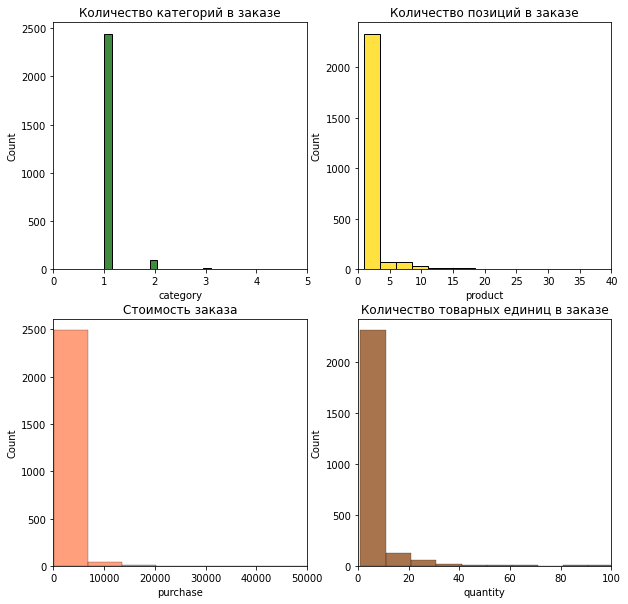

In [11]:
plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
sns.histplot(data=data, x="category", color='darkgreen', bins=20)
plt.xlim(0, 5)
plt.title('Количество категорий в заказе')


plt.subplot(2, 2, 2)
sns.histplot(data=data, x="product", color='gold', bins=20)
plt.xlim(0, 40)
plt.title('Количество позиций в заказе')


plt.subplot(2, 2, 3)
sns.histplot(data=data, x="purchase", color='coral', bins=100)
plt.title('Стоимость заказа')
plt.xlim(0, 50000)



plt.subplot(2, 2, 4)
sns.histplot(data=data, x="quantity", color='saddlebrown', bins=100)
plt.title('Количество товарных единиц в заказе')
plt.xlim(0, 100)
plt.show()








**Вывод:** Данные распределены неравномерно. Имеется явный сдвиг влево. Отбросим выпадающие значения  (для этого воспользуемся методом quantile для определения нижней и верхней границ): отбросим заказы с аномально большим количеством товарных единиц - скорее всего это "мелокооптовые" клиенты, их должно быть не так много.  

In [12]:
def emissions(i):
    lower_bound = i.quantile(q=0.025).round(0)
    upper_bound = i.quantile(q=0.975).round(0)
    return lower_bound, upper_bound

category=emissions(data['category'])
product=emissions(data['product'])
purchase=emissions(data['purchase'])
quantity=emissions(data['quantity'])
print(f'Границы количества категорий: {category}')
print(f'Границы количества позиций: {product}')
print(f'Границы стоимости: {purchase}')
print(f'Границы количества товарных единиц: {quantity}')

Границы количества категорий: (1.0, 2.0)
Границы количества позиций: (1.0, 10.0)
Границы стоимости: (59.0, 7103.0)
Границы количества товарных единиц: (1.0, 30.0)


In [13]:
data=data.query(' product<=@product[1] and quantity<=@quantity[1]')
display(data[['category','product', 'purchase', 'quantity']].describe())
x=data['order_id']
df=df.query('order_id in @x')
df.info()

,category,product,purchase,quantity
count,2456.000000,2456.000000,2456.000000,2456.000000
mean,1.040309,1.459283,1277.919381,3.165309
std,0.231007,1.453128,2110.734924,4.772156
min,1.000000,1.000000,14.000000,1.000000
25%,1.000000,1.000000,299.000000,1.000000
50%,1.000000,1.000000,712.000000,1.000000
75%,1.000000,1.000000,1499.000000,3.000000
max,4.000000,10.000000,47385.000000,30.000000


<class 'pandas.core.frame.DataFrame'>
Int64Index: 4042 entries, 0 to 6473
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         4042 non-null   datetime64[ns]
 1   customer_id  4042 non-null   object        
 2   order_id     4042 non-null   int64         
 3   product      4042 non-null   object        
 4   quantity     4042 non-null   int64         
 5   price        4042 non-null   float64       
 6   day          4042 non-null   object        
 7   lem          4042 non-null   object        
 8   category     4042 non-null   object        
 9   purchase     4042 non-null   float64       
dtypes: datetime64[ns](1), float64(2), int64(2), object(5)
memory usage: 347.4+ KB


<a id='31'></a>
### Определить период, когда количество покупок возрастает и когда снижается (день недели, время суток)

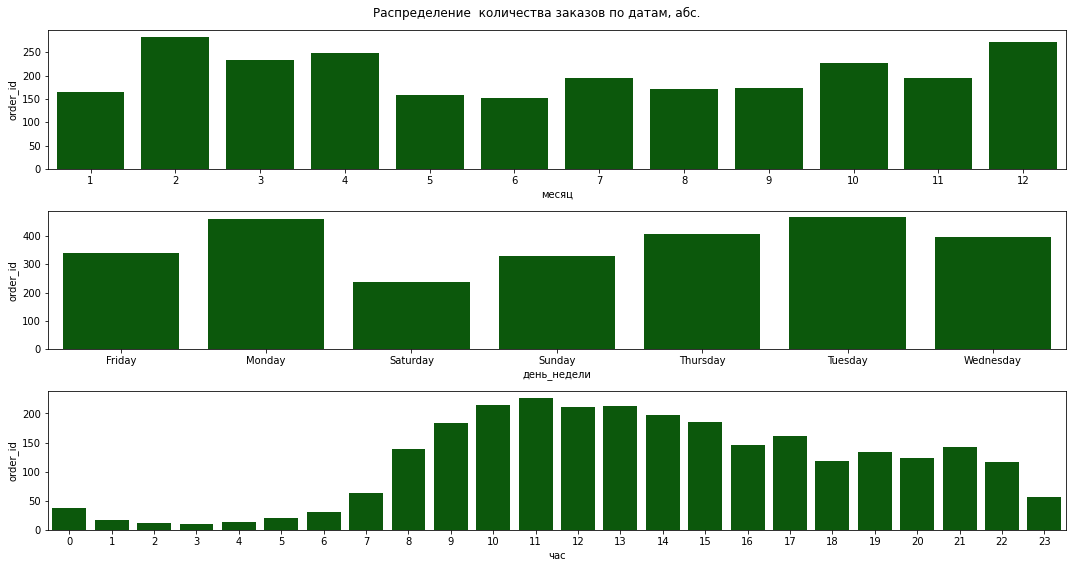

In [14]:
df['месяц']=pd.to_datetime(df['date']).dt.month
df['день_недели']=pd.to_datetime(df['date']).dt.day_name()
df['час']=pd.to_datetime(df['date']).dt.hour
time=['месяц', 'день_недели', 'час']   


def graph(x, y, z, f):
    col_count, row_count = 1,3
    plt.figure(figsize=(15, 8))
    b=0
    for i in time:
        a=df.pivot_table(index=i, aggfunc={x:f}).reset_index()
        sns.barplot(data=a, x=i, y=x, color=z, ax=plt.subplot(row_count, col_count, b+1))
        b=b+1
    plt.xlabel(i)
    plt.suptitle(f'Распределение  {y} по датам, абс.')

    plt.tight_layout()

    
graph('order_id', 'количества заказов', 'darkgreen', 'nunique')

In [15]:
df.info()
df.to_csv("best_project.csv", index=False)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4042 entries, 0 to 6473
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         4042 non-null   datetime64[ns]
 1   customer_id  4042 non-null   object        
 2   order_id     4042 non-null   int64         
 3   product      4042 non-null   object        
 4   quantity     4042 non-null   int64         
 5   price        4042 non-null   float64       
 6   day          4042 non-null   object        
 7   lem          4042 non-null   object        
 8   category     4042 non-null   object        
 9   purchase     4042 non-null   float64       
 10  месяц        4042 non-null   int64         
 11  день_недели  4042 non-null   object        
 12  час          4042 non-null   int64         
dtypes: datetime64[ns](1), float64(2), int64(4), object(6)
memory usage: 442.1+ KB


**Вывод:** На графике видно, что наибольшее количество заказов было сделано в феврале и декабре, по  понедельникам и вторникам, с 10 утра до 4х часов дня. 

<a id='32'></a>
### Определить период, когда  возрастает средний чек покупки и когда снижается (день недели, время суток)

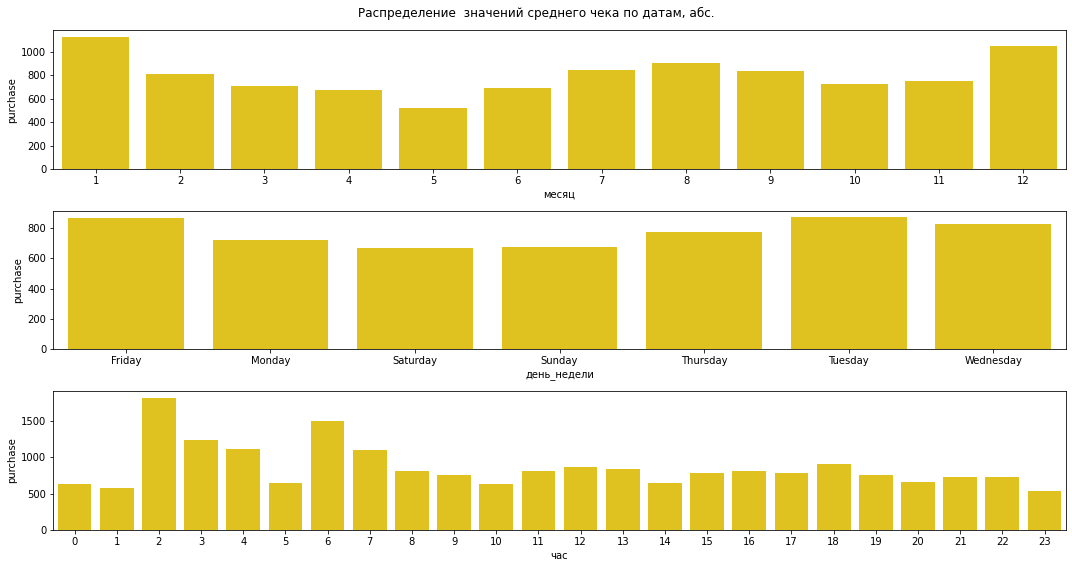

In [16]:
graph('purchase', 'значений среднего чека', 'gold', 'mean')

**Вывод:** Наиболее дорогие заказы были сделаны в декабре и январе (возможно это связано с получением годовой премии и покупкой подарков на праздники), по пятницам и в ночное время - около 2 часов ночи (возможно импульсивные покупки). 

<a id='33'></a>
### Описать распределение спроса на определенные категории товаров по дням недели, времени суток

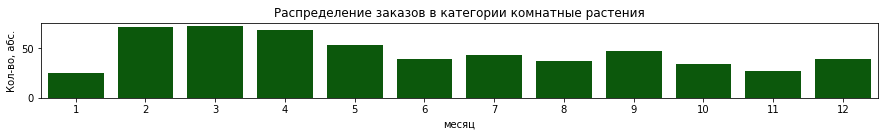

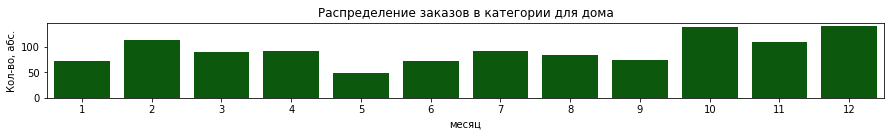

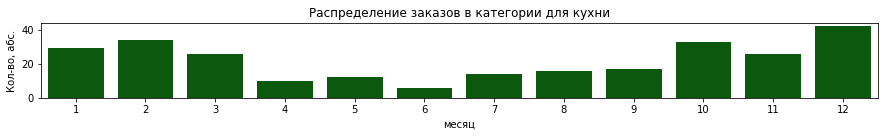

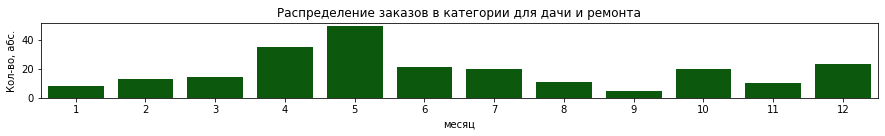

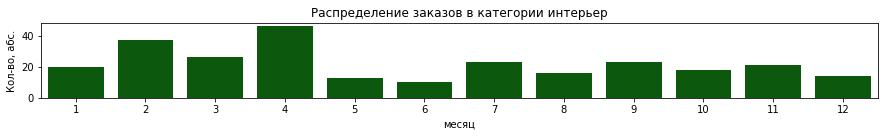

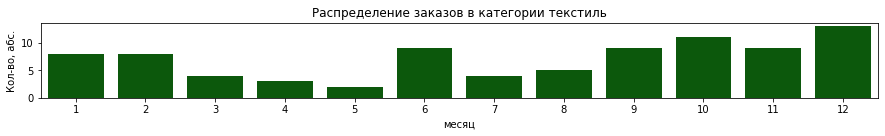

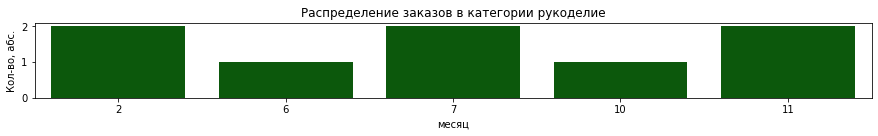

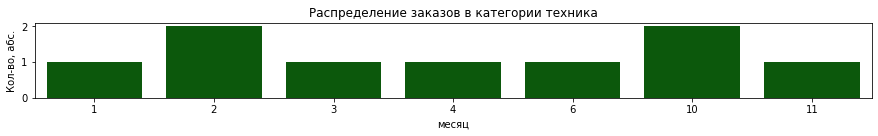

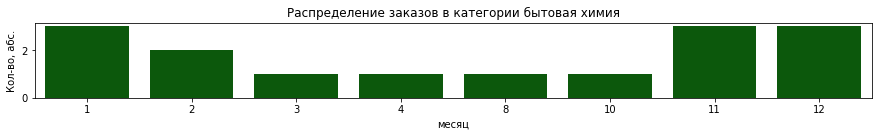

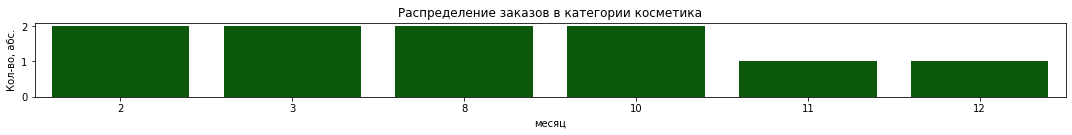

In [17]:
c=df['category'].unique()

def graph_cat(z, f):
    for cat in c:
        a=df.query('category==@cat')
        #row_count, col_count = 5, 2
        plt.figure(figsize=(15, 8))
        b=0
        a=a.pivot_table(index=a[f], aggfunc={'order_id':'nunique'}).reset_index()
        sns.barplot(data=a, x=a[f], y='order_id', color=z, ax=plt.subplot(5, 1, b+1))
        b=b+1
        plt.xlabel(f)
        plt.ylabel(f'Кол-во, абс.')
        plt.title(f'Распределение заказов в категории {cat}')
    
    plt.tight_layout()
graph_cat('darkgreen', 'месяц')

**Вывод:** Товары для дома больше покупали в октябре и декабре, товары для кухни в феврале, марте, октябре и декабре, товары для дачи и ремонта ожидаемо в апреле и мае, предметы интерьера -в феврале и апреле, текстиль в октябре и декабре. Остальные категории были не особо популярны, сравнивать 1-2 покупки в месяц нецелесообразно. 

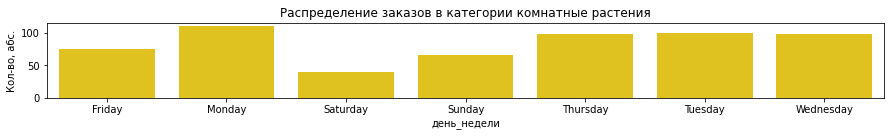

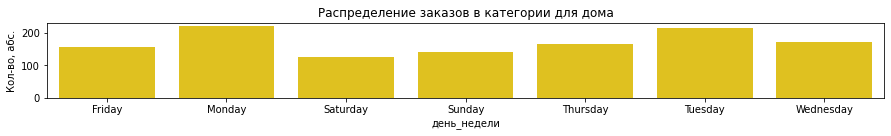

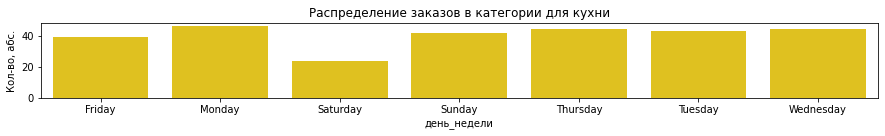

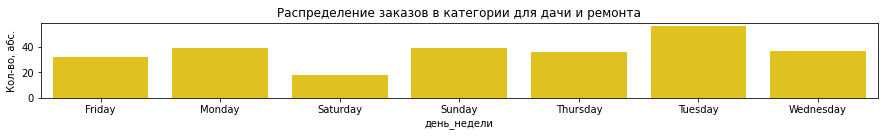

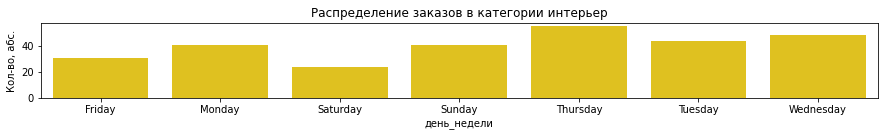

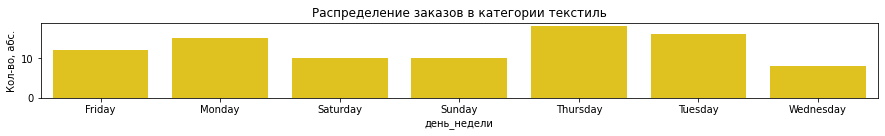

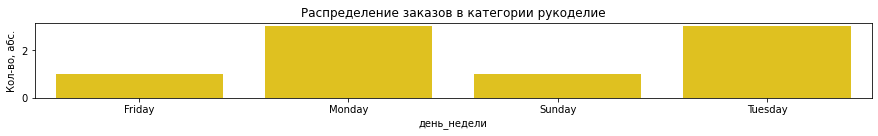

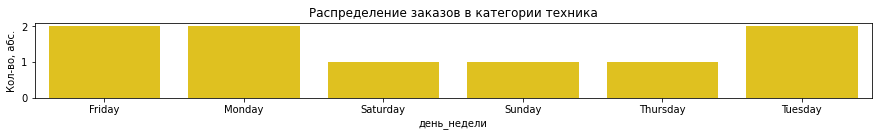

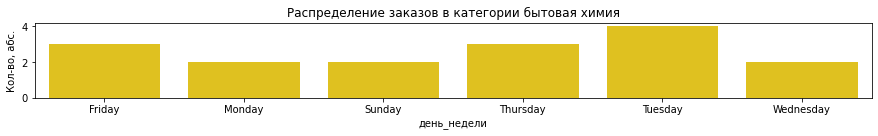

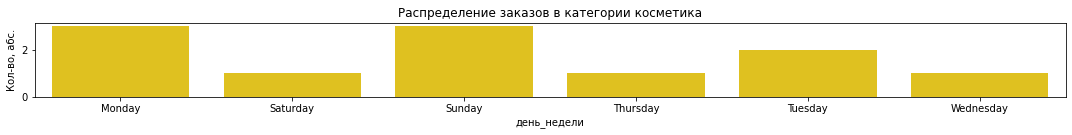

In [18]:
graph_cat('gold', 'день_недели')

**Вывод:** Товары для дома больше покупали в понедельник и среду, товары для кухни  меньше всего покупали в пятницу и субботу, товары для дачи и ремонта больше покупали в среду (вероятно, подготовка к выходным), предметы интерьера и текстиль в среду. 

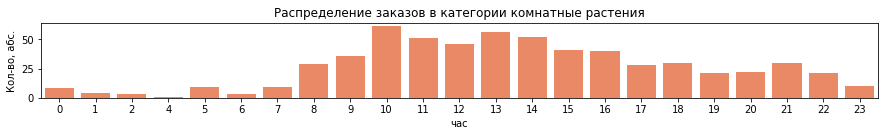

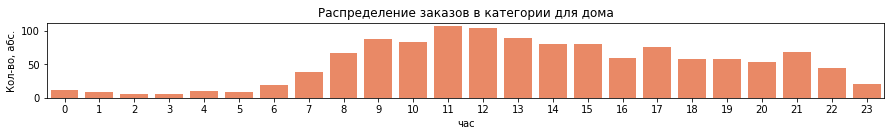

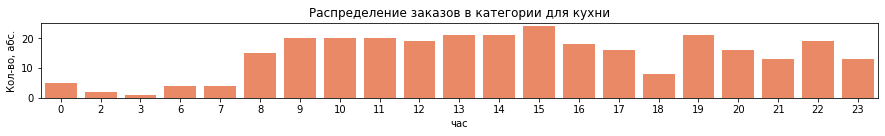

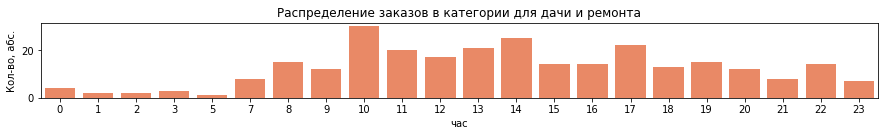

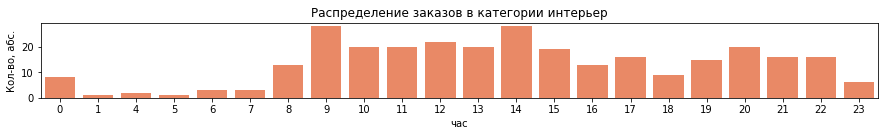

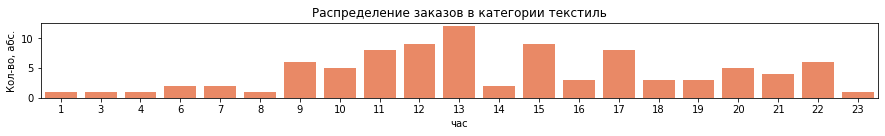

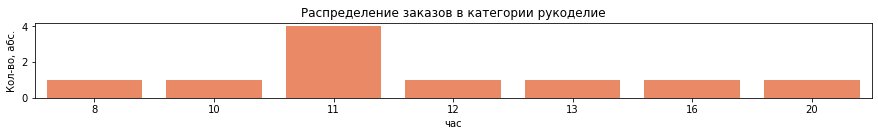

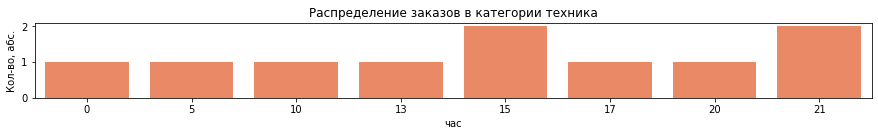

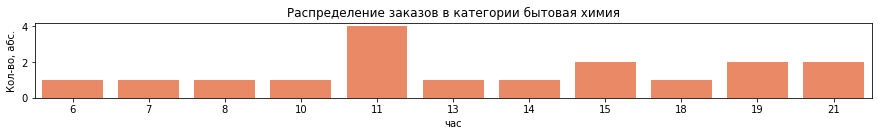

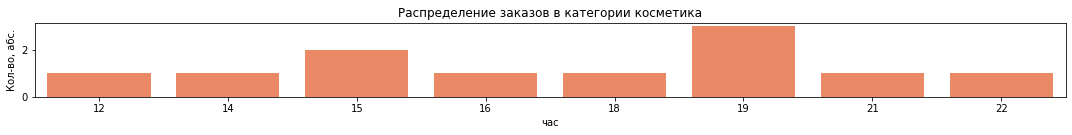

In [19]:
graph_cat('coral', 'час')

**Выводы:** Товары для дома, кухни, дачи и ремонта, предметы интерьера покупают примерно равномерно в течение дня, текстиль больше покупают в первой половине дня, технику в 3 часа дня и 9 вечера, бытовую химию и предметы для рукоделия в 11 утра. 

<a id='34'></a>
### Описать выручку и средний чек по категориям товаров

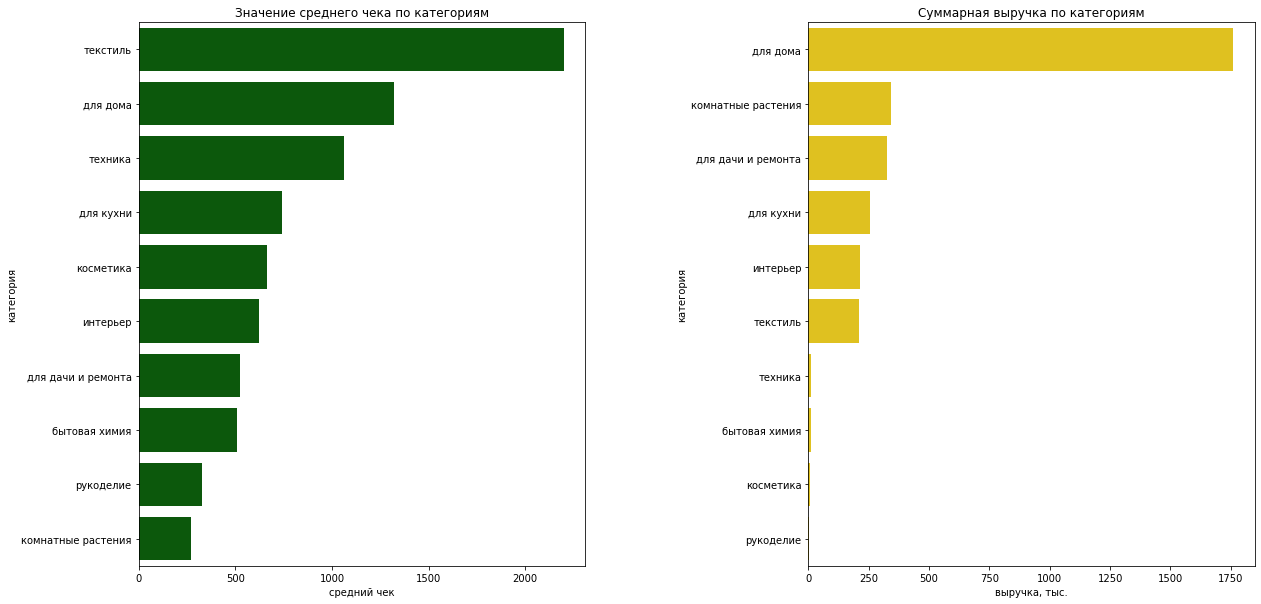

,категория,"выручка, тыс."
2,для дома,1760.85
5,комнатные растения,343.47
1,для дачи и ремонта,324.26
3,для кухни,253.96
4,интерьер,213.92
8,текстиль,209.02
9,техника,10.62
0,бытовая химия,10.22
6,косметика,8.61
7,рукоделие,3.63


,категория,средний чек
8,текстиль,2200.0
2,для дома,1321.0
9,техника,1062.0
3,для кухни,740.0
6,косметика,663.0
4,интерьер,625.0
1,для дачи и ремонта,525.0
0,бытовая химия,511.0
7,рукоделие,330.0
5,комнатные растения,273.0


In [20]:
plt.figure(figsize=(20, 10))
plt.subplots_adjust(wspace=0.5, hspace=0.5)
plt.subplot(1, 2, 1)
a=df.pivot_table(index='category', aggfunc={'purchase':'mean'}).reset_index()
a=(a.rename(columns={'category':'категория', 'purchase':'средний чек'})
   .sort_values(by='средний чек', ascending=False))
a['средний чек']=a['средний чек'].round(0)
sns.barplot(data=a, x='средний чек', y='категория', color='darkgreen')
plt.xlabel('средний чек')



plt.title(f'Значение среднего чека по категориям')

plt.subplot(1, 2, 2)
v=df.pivot_table(index='category', aggfunc={'purchase':'sum'}).reset_index()
v['purchase']=(v['purchase']/1000).round(2)
v=(v.rename(columns={'category':'категория', 'purchase':'выручка, тыс.'})
   .sort_values(by='выручка, тыс.', ascending=False))
sns.barplot(data=v, x='выручка, тыс.', y='категория', color='gold')
plt.xlabel('выручка, тыс.')


plt.title(f'Суммарная выручка по категориям')

plt.show()
display(v)
display(a)

**Вывод:** Наибольшую выручку приносит категории товаров для дома, комнатные растения, товары для дачи и ремонта. Наибольший средний чек у категорий текстиль, товары для дома и техника. 

<a id='4'></a>
## Сформулировать и проверить гипотезы: (различии среднего количества покупок и среднего чека по дням недели, времени суток, о различии спроса на определенные категории товаров в течение недели, времени суток)

Создадим функцию для проверки гипотез

In [21]:
def stat(a, b):
    alpha = .01 

    results = st.ttest_ind(a, b, equal_var = False)

    print('p-значение:', results.pvalue)

    if results.pvalue < alpha:
        print("Отвергаем нулевую гипотезу")
    else:
        print("Не получилось отвергнуть нулевую гипотезу") 
    

<a id='41'></a>
### Гипотеза о продажах по сезонам

**Нулевая гипотеза:** Количество заказов зимой и летом достоверно не различается.

**Альтернативная гипотеза:** Количество заказов зимой и летом  достоверно различается.

**Нулевая гипотеза:** Количество заказов весной и осенью достоверно не различается.

**Альтернативная гипотеза:** Количество заказов весной и осенью  достоверно различается.

In [22]:
winter=(df.query('месяц==1 or месяц==2 or месяц==12')
        .pivot_table(index='date', aggfunc={'order_id':'nunique'})
        .reset_index().loc[:, 'order_id'])
print('Количество заказов зимой:', winter.sum())
summer=(df.query('месяц==6 or месяц==7 or месяц==8')
        .pivot_table(index='date', aggfunc={'order_id':'nunique'})
        .reset_index().loc[:, 'order_id'])
print('Количество заказов летом:', summer.sum())
stat(winter, summer)

Количество заказов зимой: 820
Количество заказов летом: 579
p-значение: 6.9818066293832985e-06
Отвергаем нулевую гипотезу


**Вывод:** В зимнее время заказов достоверно больше. 

In [23]:
spring=(df.query('месяц==3 or месяц==4 or месяц==5')
        .pivot_table(index='date', aggfunc={'order_id':'nunique'})
        .reset_index().loc[:, 'order_id'])
print('Количество заказов весной:', spring.sum())
autumn=(df.query('месяц==9 or месяц==10 or месяц==11')
        .pivot_table(index='date', aggfunc={'order_id':'nunique'})
        .reset_index().loc[:, 'order_id'])
print('Количество заказов осенью:', autumn.sum())
stat(spring, autumn)

Количество заказов весной: 763
Количество заказов осенью: 645
p-значение: 0.04732663997231151
Не получилось отвергнуть нулевую гипотезу


**Вывод:** Количество заказов осенью и весной достоверно не различается. 

<a id='42'></a>
### Гипотеза о продажах по дням недели

**Нулевая гипотеза:** Количество заказов с понедельника по четверг достоверное не отличается от количества заказов с пятницы по воскресенье.

**Альтернативная гипотеза:** Количество заказов с понедельника по четверг достоверно отличается от количества заказов с пятницы по воскресенье.

In [24]:

first=(df.query('день_недели=="Monday" or день_недели=="Tuesday" or день_недели=="Wednesday" or день_недели=="Thursday"')
        .pivot_table(index='date', aggfunc={'order_id':'nunique'})
        .reset_index().loc[:, 'order_id'])
print('Количество заказов c понедельника по четверг:', spring.sum())
second=(df.query('день_недели=="Friday" or день_недели=="Saturday" or день_недели=="Sunday"')
        .pivot_table(index='date', aggfunc={'order_id':'nunique'})
        .reset_index().loc[:, 'order_id'])
print('Количество заказов с пятницы по воскресенье:', autumn.sum())
stat(first, second)

Количество заказов c понедельника по четверг: 763
Количество заказов с пятницы по воскресенье: 645
p-значение: 4.5514217153499485e-06
Отвергаем нулевую гипотезу


**Вывод:** Количество заказов с понедельника по четверг достоверно больше, чем с пятницу по воскресенье.  

<a id='43'></a>
### Гипотеза о различии выручки по категориям комнатные растения и товары для дачи и ремонта

По величине выручки есть явный лидер - товары для дома, сравнивать выручку по этой категории с другими не имеет смысла, она более чем в 5 раз превышает следующую по значению выручку. А вот сравнить между собой категории, занимающие второе и третье ранговые места интересно.  

**Нулевая гипотеза:** Выручка по категориям комнатные растения и товары для дачи и ремонта достоверно не различается. 

**Альтернативная гипотеза:** Выручка по категориям комнатные растения и товары для дачи и ремонта достоверно  различается.

In [25]:
df['category'].unique()

array(['комнатные растения', 'для дома', 'для кухни',
       'для дачи и ремонта', 'интерьер', 'текстиль', 'рукоделие',
       'техника', 'бытовая химия', 'косметика'], dtype=object)

In [26]:
plants=(df.query('category=="комнатные растения"')
        .pivot_table(index='order_id', aggfunc={'purchase':'sum'})
        .reset_index().loc[:, 'purchase'])
print('Выручка категории комнатные растения:', plants.sum())
repair=(df.query('category=="для дачи и ремонта"')
        .pivot_table(index='order_id', aggfunc={'purchase':'sum'})
        .reset_index().loc[:, 'purchase'])
print('Выручка категории товары для дачи и ремонта:', repair.sum())
stat(plants, repair)

Выручка категории комнатные растения: 343474.0
Выручка категории товары для дачи и ремонта: 324258.0
p-значение: 1.0345083019893843e-05
Отвергаем нулевую гипотезу


**Вывод:** Выручка категории комнтатные растения достоверно больше, чем выручка категории товары для дачи и ремонта. 

<a id='44'></a>
### Гипотеза о различии среднего чека по категориям товары для дома и техника


По значению среднего чека есть явный лидер - текстиль, сравнивать средний чек по этой категории с другими не имеет смысла, он почти в 2 раза превышает следующий по значению средний чек. А вот сравнить между собой категории, занимающие второе и третье ранговые места интересно. 

**Нулевая гипотеза:** Средний чек по категориям товары для дома  и техника достоверно не различается. 

**Альтернативная гипотеза:** Средний чек по категориям товары для дома  и техника достоверно  различается.

In [27]:
home=(df.query('category=="для дома"')
        .pivot_table(index='order_id', aggfunc={'purchase':'mean'})
        .reset_index().loc[:, 'purchase'])
print('Средний чек категории товары для дома:', a.loc[2, 'средний чек'])
technique=(df.query('category=="техника"')
        .pivot_table(index='order_id', aggfunc={'purchase':'mean'})
        .reset_index().loc[:, 'purchase'])
print('Средний чек категории техника:', a.loc[9, 'средний чек'])
stat(home, technique)

Средний чек категории товары для дома: 1321.0
Средний чек категории техника: 1062.0
p-значение: 0.41309783584916904
Не получилось отвергнуть нулевую гипотезу


**Вывод:** Средний чек по категориям товары для дома и техника достоверно не различается. 

<a id='5'></a> 
## Создать сводную таблицу по покупателям, определить количество совершенных покупок, среднее количество товаров в заказе, средний чек, категории выбранных товаров

Преобразуем строковые значений признака "Категория" и "Номер покупателя" в числовые. 

In [28]:
encoder =  LabelEncoder() 

df['customer_id']=encoder.fit_transform(df['customer_id']) 

In [29]:
data=df.pivot_table(index='customer_id', aggfunc={'order_id':'nunique', 
                                                  'purchase':'mean', 
                                                  'product':'nunique', 
                                                  'quantity':'mean',
                                                  'category':lambda x: x.mode().iat[0],
                                                  'месяц':lambda x: x.mode().iat[0],
                                                  'день_недели':lambda x: x.mode().iat[0]}).reset_index()
data['category'] = encoder.fit_transform(data['category']) 
data['день_недели'] = encoder.fit_transform(data['день_недели']) 

<a id='6'></a> 
## Провести сегментацию покупателей

<a id='61'></a>
### Провести стандартизацию данных

In [30]:
scaler = StandardScaler() 
x_st = scaler.fit_transform(data)

<a id='62'></a>
### Построить дендрограмму

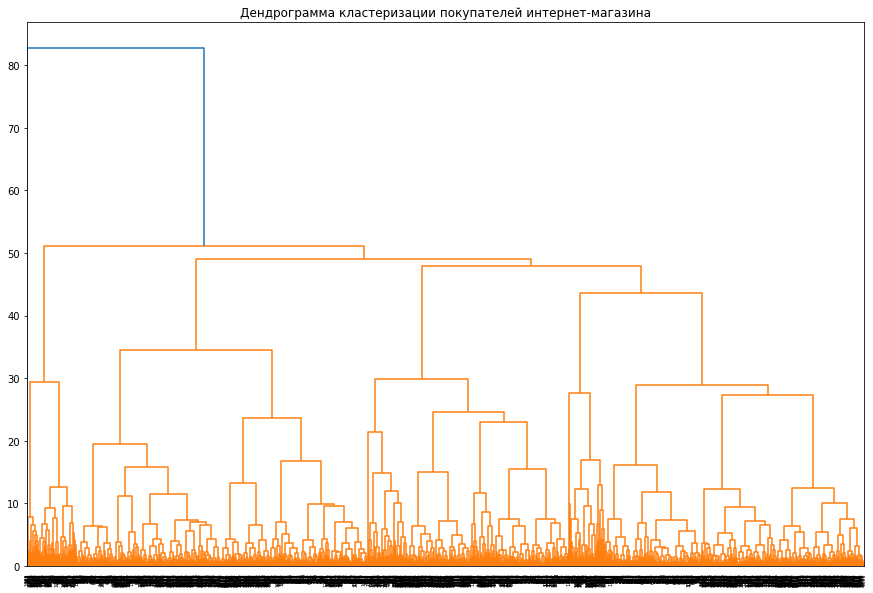

In [31]:
linked = linkage(x_st, method = 'ward')
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Дендрограмма кластеризации покупателей интернет-магазина')
plt.show() 

**Вывод:** Можно провести линию на уровне 40 и разделить покупателей на 5 кластеров. 

<a id='63'></a>
### Обучить модель кластеризации на основании алгоритма K-Means

In [32]:
km = KMeans(n_clusters = 5, random_state=0)
labels = km.fit_predict(x_st)


data['cluster_km'] = labels

# посчитаем метрику силуэта для нашей кластеризации
print('Silhouette_score: {:.2f}'.format(silhouette_score(x_st, labels)))

Silhouette_score: 0.16


**Выводы:** Значение метрики не очень высокая, значит результаты кластеризации нужно будет дополнительно обсудить.  

<a id='64'></a> 
### Оценить средние значения признаков для кластеров

In [33]:
data=data[['customer_id', 'cluster_km']]
print(data['customer_id'].nunique(), df['customer_id'].nunique())
df=df.merge( data, on='customer_id', how="left")


2141 2141


Проверим численность групп:

In [34]:
display(df.groupby('cluster_km')['customer_id'].nunique())
df=df.query('cluster_km!=2')
df=df.replace({'cluster_km':{0:'группа_1', 1:'группа_2', 3:'группа_3', 4:'группа_4'}})

cluster_km
0    751
1    666
2      1
3     75
4    648
Name: customer_id, dtype: int64

**Комментарий:** Я пыталась провести кластеризацию добавляя и удаляя признаки, делила на разное количество групп, но всегда выделяется кластер с 1 уникальным покупателем. Далее я не буду описывать этот кластер и буду писать, что поделили покупателей на 4 группы.  

**Оценим динамику покупок по кластерам и датам**


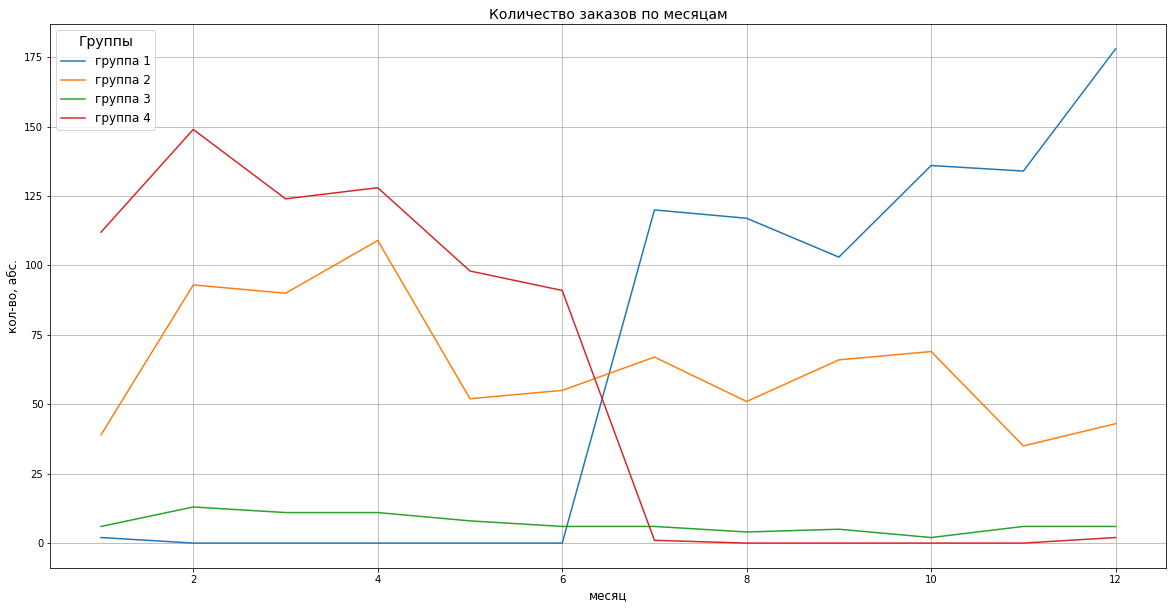

In [35]:
def group(x, y):
    month=(df.pivot_table(index=x, columns='cluster_km', aggfunc={'order_id':'nunique'}).reset_index()
           .fillna(0))
    month.columns=[x, 'группа 1', 'группа 2', 'группа 3', 'группа 4']
    month.plot(x=x, grid=True, figsize=(20,10))
    plt.title(f'Количество заказов по {y}', fontsize=14)
    plt.xlabel(x, fontsize=12)
    plt.ylabel('кол-во, абс.', fontsize=12)          
    plt.legend(fontsize = 12,
               title = 'Группы',    
               title_fontsize = '14')
    plt.show()
    
group('месяц', 'месяцам')

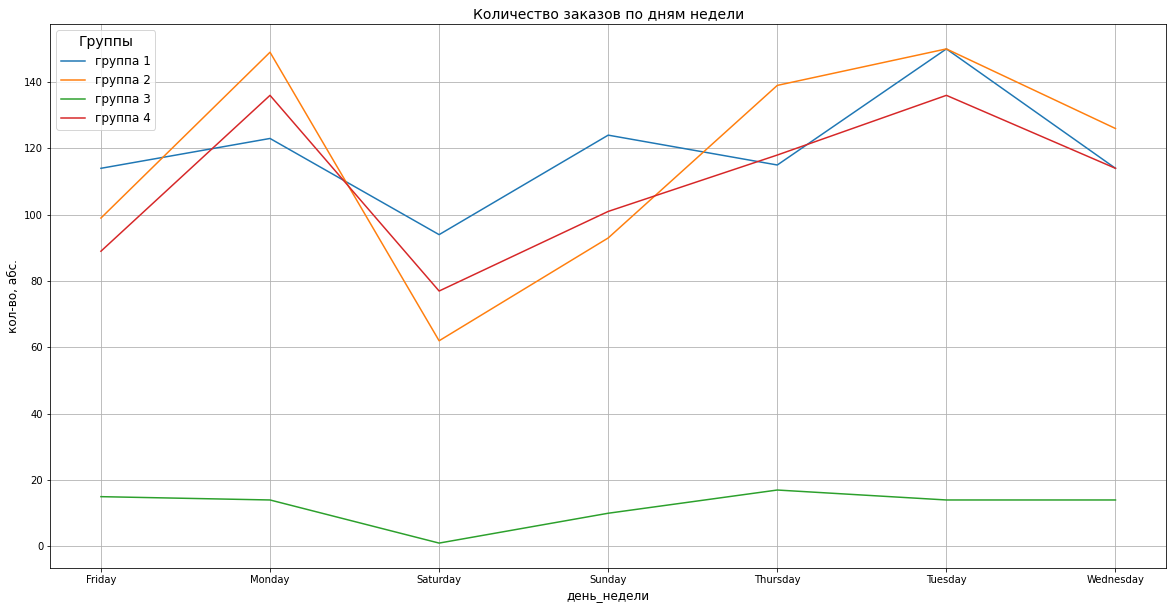

In [36]:
group('день_недели', 'дням недели')

**Оценим средний чек и выручку по группам**

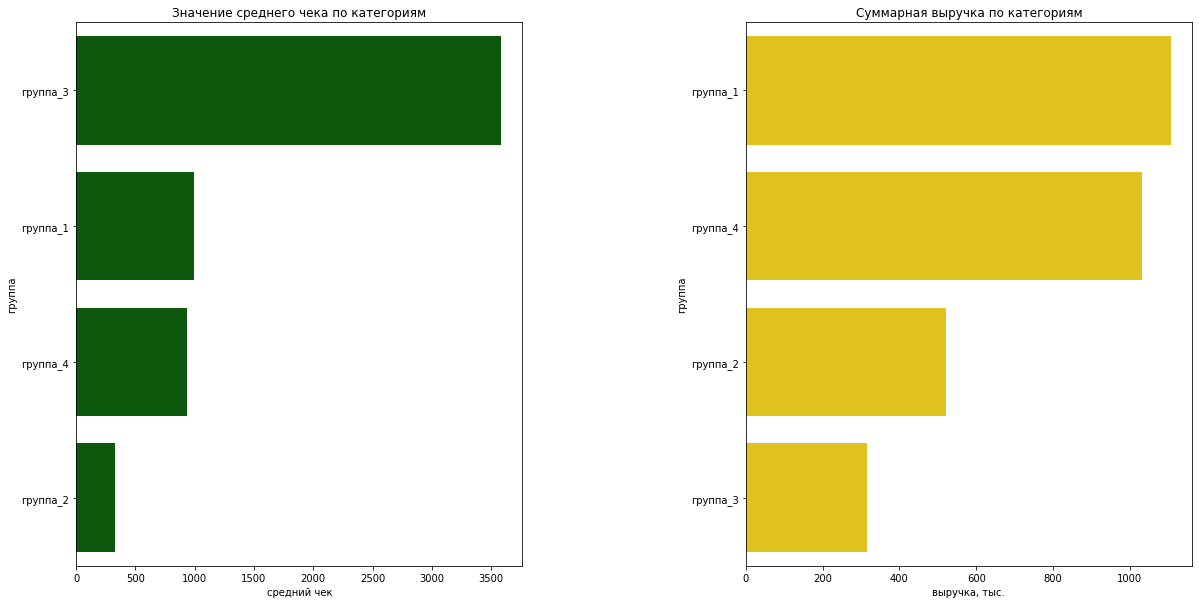

,группа,"выручка, тыс."
0,группа_1,1106.42
3,группа_4,1030.85
1,группа_2,520.07
2,группа_3,315.46


,группа,средний чек
2,группа_3,3585.0
0,группа_1,996.0
3,группа_4,937.0
1,группа_2,325.0


In [37]:
plt.figure(figsize=(20, 10))
plt.subplots_adjust(wspace=0.5, hspace=0.5)
plt.subplot(1, 2, 1)
a=df.pivot_table(index='cluster_km', aggfunc={'purchase':'mean'}).reset_index()
a=(a.rename(columns={'cluster_km':'группа', 'purchase':'средний чек'})
   .sort_values(by='средний чек', ascending=False))
a['средний чек']=a['средний чек'].round(0)
sns.barplot(data=a, x='средний чек', y='группа', color='darkgreen')
plt.xlabel('средний чек')



plt.title(f'Значение среднего чека по категориям')

plt.subplot(1, 2, 2)
v=df.pivot_table(index='cluster_km', aggfunc={'purchase':'sum'}).reset_index()
v['purchase']=(v['purchase']/1000).round(2)
v=(v.rename(columns={'cluster_km':'группа', 'purchase':'выручка, тыс.'})
   .sort_values(by='выручка, тыс.', ascending=False))
sns.barplot(data=v, x='выручка, тыс.', y='группа', color='gold')
plt.xlabel('выручка, тыс.')


plt.title(f'Суммарная выручка по категориям')

plt.show()
display(v)
display(a)

**Оценим любимые категории по группам клиентов**

In [38]:
print ('Таблица 1. Все категории группы')
display(df.pivot_table(index='cluster_km', aggfunc={'category':'unique'}).reset_index())
print ('Таблица 2. Любимая категория группы')
display(df.pivot_table(index='cluster_km', aggfunc={'category':lambda x: x.mode().iat[0]}).reset_index())

Таблица 1. Все категории группы


,cluster_km,category
0,группа_1,"[для дома, для кухни, комнатные растения, для дачи и ремонта, интерьер, бытовая химия, косметика, техника, текстиль]"
1,группа_2,"[комнатные растения, для дома, для кухни, текстиль, интерьер, рукоделие, техника, для дачи и ремонта, косметика, бытовая химия]"
2,группа_3,"[интерьер, для кухни, текстиль, для дачи и ремонта, для дома, комнатные растения, рукоделие]"
3,группа_4,"[для дома, для кухни, для дачи и ремонта, интерьер, бытовая химия, комнатные растения]"


Таблица 2. Любимая категория группы


,cluster_km,category
0,группа_1,для дома
1,группа_2,комнатные растения
2,группа_3,интерьер
3,группа_4,для дома


**Описание 1 группы покупателей - самые прибыльные**

Первая группа покупателей приносит самую большую выручку интернет-магазину. По величине среднего чека эта группа находится на втором месте. Характерная особенность - количество заказов в этой группе начинает увеличиваться во второй половине года достигая максимума в декабре. Чаще всего эти покупатели делают заказы по средам. Покупателям из этой группы интересны все категории товаров, кроме товаров для рукоделия. Любимая категория - товары для дома. 

**Описание 2 группы покупателей - стабильные**

Вторая группа покупателей по величине выручки находится на предпоследнем месте. Величина среднего чека - самая маленькая, но при этом они стабильно делают заказы на протяжении всего года, незначительно больше в первой половине. Чаще всего эти покупатели делают заказы по понедельникам средам и четвергам. Покупателям из этой группы интересны все категории товаров. Любимая категория - комнатные растения. 

**Описание 3 группы покупателей - любят дорогие покупки** 

Третья группа покупателей приносит меньше всего выручки магазину, при этом любят совершать дорогие покупки (самый большой средний чек). Эти покупатели совершают заказы равномерно нечасто на протяжении всего года.  По дням недели они совершают покупки также стабильно нечасто, но выражено снижение кол-ва заказов в субботу. Покупателям из этой группы интересны  категории товаров: интерьер, для кухни, текстиль, для дачи и ремонта, для дома, комнатные растения, рукоделие. Любимая категория - предметы интерьера.

**Описание 4 группы покупателей - дачники**

Четвертая группа покупателей приносит вторую по величине выручку интернет-магазину. По величине среднего чека эта группа находится на третьем месте, не сильно уступая 1 группе. Характерная особенность - количество заказов в этой группе максимально в феврале, постепенно снижается к июлю и во второй половине года заказы практически не совершаются. Чаще всего эти покупатели делают заказы по понедельникам и средам. Покупателям из этой группы интересны 'бытовые' категории товаров: для дома, для кухни, для дачи и ремонта, интерьер, бытовая химия, комнатные растения. Любимая категория - товары для дома. Особенность динамики совершения заказов и категории выбранных товаров наталкивают на мысль, что это группа покупателей активно увлекающихся садоводством. 

<a id='7'></a>
## Дать рекомендации по персонифицированным предложениям для каждого сегмента покупателей

**Рекомендации для первой группы:**

Этой группе покупателей интересно всё. Они итак приносят самую большую выручку, но можно попробовать увеличить величину среднего чека, предлагая купоны на скидку от определенной суммы заказа. Также можно предлагать скидки за отзывы. Эти покупатели активно будут участвовать в предновогодних распродажах. 

**Рекомендации для второй группы:**

Этой группе покупателей также интересно всё. Они стабильно делают заказы на протяжении всего года, но количество заказов невелико, поэтому для увеличения количества заказов можно предлагать купоны на скидку на следующий заказ. 

**Рекомендации для третьей группы:**

Эти покупатели совершают самые дорогие, но редкие покупки. Им должна быть интересна рассылка на "эксклюзивные" коллекции текстиля и предметов интерьера. Акцентировать внимание нужно на эксклюзивности и эстетичности предложенных товаров.  

**Рекомендации для четвертой группы:** Для этой категории покупателей интересно все, что связано с домом и дачей. Они активно включатся в сезонные акции (весна и лето). Акцентировать внимание нужно на загородной тематике и уюте. 

**Рекомндации по рассылке по дням недели:** Самое оптимальное время для рассылки - первая половина недели. Самое неудачное время - пятница и суббота. 